In [3]:
!nvidia-smi

Fri Mar  1 14:23:25 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   47C    P8    18W / 170W |    325MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.chdir('..')
os.getcwd()

'/home/bunny/projects/IConNet'

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [8]:
data_dir = '../data/esd/features_4balanced/'

sr = 16000

In [9]:
x_train = np.load(f'{data_dir}esd.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}esd.audio16k.test.npy', allow_pickle=True)

In [10]:
y_train = np.load(f'{data_dir}esd.label_emotion.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}esd.label_emotion.test.npy', allow_pickle=True)

In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
labels = ['ang', 'neu', 'sad', 'hap']
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
import traceback
from IConNet.nn.model import M13mel as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 40, 'n_fft': 512, 'hop_length': 128, 'n_mels': 64, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mel(
  (mfcc): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [14]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [15]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [16]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                   | 0.001142857142857143/10 [00:01<3:25:13, 1231.49s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.500821
Mem before-during-after: 1265664 9929216 21898752


  0%|▏                                                                     | 0.023999999999999983/10 [00:08<49:55, 300.27s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.261140
Mem before-during-after: 21898752 22041600 21898752


  0%|▎                                                                     | 0.046857142857142785/10 [00:15<49:06, 296.03s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.158203
Mem before-during-after: 21898752 22041600 21898752


  1%|▍                                                                      | 0.06971428571428559/10 [00:22<49:34, 299.56s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.121368
Mem before-during-after: 21898752 22041600 21898752


  1%|▋                                                                      | 0.09257142857142839/10 [00:28<48:40, 294.81s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.307369
Mem before-during-after: 21898752 22041600 21898752


  1%|▊                                                                      | 0.11542857142857119/10 [00:35<49:28, 300.34s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 0.966524
Mem before-during-after: 21898752 22041600 21898752


  1%|▉                                                                      | 0.13828571428571432/10 [00:42<48:40, 296.13s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.267084
Mem before-during-after: 21898752 22041600 21898752


  2%|█▏                                                                     | 0.16114285714285767/10 [00:49<49:58, 304.72s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.136781
Mem before-during-after: 21898752 22041600 21898752


  2%|█▎                                                                     | 0.18400000000000102/10 [00:56<49:17, 301.31s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 0.834885
Mem before-during-after: 21898752 22041600 21898752


  2%|█▍                                                                     | 0.20685714285714438/10 [01:03<47:58, 293.95s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 0.976670
Mem before-during-after: 21898752 22041600 21898752


  2%|█▋                                                                     | 0.22971428571428773/10 [01:10<47:57, 294.50s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.574221
Mem before-during-after: 21898752 22041600 21898752


  3%|█▊                                                                     | 0.25257142857143094/10 [01:16<47:20, 291.45s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.387433
Mem before-during-after: 21898752 22041600 21898752


  3%|█▉                                                                      | 0.2754285714285732/10 [01:23<48:32, 299.45s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.221596
Mem before-during-after: 21898752 22041600 21898752


  3%|██                                                                     | 0.29828571428571543/10 [01:30<47:11, 291.86s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 0.765532
Mem before-during-after: 21898752 22041600 21898752


  3%|██▎                                                                     | 0.3211428571428577/10 [01:37<48:49, 302.68s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 0.898065
Mem before-during-after: 21898752 22041600 21898752


  3%|██▍                                                                     | 0.3439999999999999/10 [01:44<46:39, 289.96s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.224065
Mem before-during-after: 21898752 22041600 21898752


  4%|██▌                                                                    | 0.36685714285714216/10 [01:50<47:26, 295.52s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.276649
Mem before-during-after: 21898752 22041600 21898752


  4%|██▊                                                                     | 0.3897142857142844/10 [01:57<46:49, 292.36s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.349641
Mem before-during-after: 21898752 22041600 21898752


  4%|██▉                                                                    | 0.41257142857142665/10 [02:04<47:55, 299.97s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 0.901645
Mem before-during-after: 21898752 22041600 21898752


  4%|███▏                                                                    | 0.4354285714285689/10 [02:11<47:51, 300.19s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 0.630003
Mem before-during-after: 21898752 22041600 21898752


  5%|███▎                                                                   | 0.45828571428571113/10 [02:17<46:51, 294.63s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 1.104058
Mem before-during-after: 21898752 22041600 21898752


  5%|███▍                                                                    | 0.4811428571428534/10 [02:24<47:25, 298.92s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 0.924523
Mem before-during-after: 21898752 22041600 21898752


  5%|███▋                                                                    | 0.5039999999999957/10 [02:31<46:26, 293.49s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 0.886730
Mem before-during-after: 21898752 22041600 21898752


  5%|███▊                                                                    | 0.5268571428571379/10 [02:38<48:55, 309.83s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.079029
Mem before-during-after: 21898752 22041600 21898752


  5%|███▉                                                                    | 0.5497142857142802/10 [02:45<46:07, 292.82s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 0.935834
Mem before-during-after: 21898752 22041600 21898752


  6%|████                                                                    | 0.5725714285714224/10 [02:51<46:26, 295.59s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 0.770513
Mem before-during-after: 21898752 22041600 21898752


  6%|████▎                                                                   | 0.5954285714285646/10 [02:58<46:31, 296.87s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 1.158395
Mem before-during-after: 21898752 22041600 21898752


  6%|████▍                                                                   | 0.6182857142857069/10 [03:05<46:35, 298.00s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 0.798745
Mem before-during-after: 21898752 22041600 21898752


  6%|████▌                                                                   | 0.6411428571428491/10 [03:12<47:18, 303.31s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 0.967188
Mem before-during-after: 21898752 22041600 21898752


  7%|████▊                                                                   | 0.6639999999999914/10 [03:19<45:58, 295.42s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 0.985820
Mem before-during-after: 21898752 22041600 21898752


  7%|████▉                                                                   | 0.6868571428571336/10 [03:26<45:54, 295.75s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 0.743146
Mem before-during-after: 21898752 22041600 21898752


  7%|█████                                                                   | 0.7097142857142759/10 [03:32<45:31, 293.98s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 1.045553
Mem before-during-after: 21898752 22041600 21898752


  7%|█████▎                                                                  | 0.7325714285714181/10 [03:39<45:23, 293.89s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 1.037033
Mem before-during-after: 21898752 22041600 21898752


  8%|█████▍                                                                  | 0.7554285714285603/10 [03:46<45:30, 295.41s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 0.883561
Mem before-during-after: 21898752 22041600 21898752


  8%|█████▌                                                                  | 0.7782857142857026/10 [03:53<45:18, 294.84s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 0.972253
Mem before-during-after: 21898752 22041600 21898752


 10%|███████▎                                                                 | 1.000571428571411/10 [04:59<44:22, 295.82s/it]


Test Epoch: 1	Accuracy: 1393/5600 (25%)

Train Epoch: 2 [0/22400 (0%)]	Loss: 0.823183
Mem before-during-after: 21897728 22041600 21898752


 10%|███████▎                                                                | 1.0239999999999863/10 [05:06<43:29, 290.77s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 0.803271
Mem before-during-after: 21898752 22041600 21898752


 10%|███████▋                                                                 | 1.046857142857133/10 [05:12<43:37, 292.31s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 0.807656
Mem before-during-after: 21898752 22041600 21898752


 11%|███████▋                                                                | 1.0697142857142796/10 [05:19<43:21, 291.34s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 1.237314
Mem before-during-after: 21898752 22041600 21898752


 11%|███████▊                                                                | 1.0925714285714263/10 [05:26<43:24, 292.36s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 1.673346
Mem before-during-after: 21898752 22041600 21898752


 11%|████████▏                                                                | 1.115428571428573/10 [05:33<43:29, 293.66s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 0.746015
Mem before-during-after: 21898752 22041600 21898752


 11%|████████▏                                                               | 1.1382857142857197/10 [05:39<43:30, 294.60s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 0.936379
Mem before-during-after: 21898752 22041600 21898752


 12%|████████▎                                                               | 1.1611428571428664/10 [05:46<48:21, 328.22s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 0.956597
Mem before-during-after: 21898752 22041600 21898752


 12%|████████▋                                                                | 1.184000000000013/10 [05:53<43:54, 298.89s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 0.866547
Mem before-during-after: 21898752 22041600 21898752


 12%|████████▋                                                               | 1.2068571428571597/10 [06:00<43:38, 297.84s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 0.932550
Mem before-during-after: 21898752 22041600 21898752


 12%|████████▊                                                               | 1.2297142857143064/10 [06:07<42:57, 293.87s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 0.875354
Mem before-during-after: 21898752 22041600 21898752


 13%|█████████▏                                                               | 1.252571428571453/10 [06:14<42:40, 292.69s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 1.735060
Mem before-during-after: 21898752 22041600 21898752


 13%|█████████▏                                                              | 1.2754285714285998/10 [06:21<43:05, 296.35s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.865586
Mem before-during-after: 21898752 22041600 21898752


 13%|█████████▎                                                              | 1.2982857142857465/10 [06:27<43:35, 300.58s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 0.682361
Mem before-during-after: 21898752 22041600 21898752


 13%|█████████▌                                                              | 1.3211428571428931/10 [06:34<44:17, 306.24s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 1.292965
Mem before-during-after: 21898752 22041600 21898752


 13%|█████████▋                                                              | 1.3440000000000398/10 [06:41<43:10, 299.31s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 0.812702
Mem before-during-after: 21898752 22041600 21898752


 14%|█████████▊                                                              | 1.3668571428571865/10 [06:48<42:59, 298.84s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 0.982791
Mem before-during-after: 21898752 22041600 21898752


 14%|██████████                                                              | 1.3897142857143332/10 [06:55<43:24, 302.45s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 1.107137
Mem before-during-after: 21898752 22041600 21898752


 14%|██████████▏                                                             | 1.4125714285714799/10 [07:02<42:23, 296.24s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 1.515078
Mem before-during-after: 21898752 22041600 21898752


 14%|██████████▎                                                             | 1.4354285714286266/10 [07:09<42:54, 300.57s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.786135
Mem before-during-after: 21898752 22041600 21898752


 15%|██████████▍                                                             | 1.4582857142857732/10 [07:16<43:03, 302.52s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 0.676352
Mem before-during-after: 21898752 22041600 21898752


 15%|██████████▉                                                               | 1.48114285714292/10 [07:23<42:29, 299.32s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 1.077518
Mem before-during-after: 21898752 22041600 21898752


 15%|██████████▊                                                             | 1.5040000000000666/10 [07:29<42:05, 297.26s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 0.829451
Mem before-during-after: 21898752 22041600 21898752


 15%|██████████▉                                                             | 1.5268571428572133/10 [07:36<42:06, 298.14s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 0.986999
Mem before-during-after: 21898752 22041600 21898752


 15%|███████████▍                                                              | 1.54971428571436/10 [07:43<42:24, 301.11s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 0.814622
Mem before-during-after: 21898752 22041600 21898752


 16%|███████████▎                                                            | 1.5725714285715067/10 [07:50<42:13, 300.64s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 1.320658
Mem before-during-after: 21898752 22041600 21898752


 16%|███████████▍                                                            | 1.5954285714286534/10 [07:57<41:40, 297.54s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 1.068265
Mem before-during-after: 21898752 22041600 21898752


 16%|████████████▏                                                              | 1.6182857142858/10 [08:04<41:10, 294.70s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 1.057439
Mem before-during-after: 21898752 22041600 21898752


 16%|███████████▊                                                            | 1.6411428571429467/10 [08:10<41:23, 297.10s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 0.667628
Mem before-during-after: 21898752 22041600 21898752


 17%|███████████▉                                                            | 1.6640000000000934/10 [08:17<41:13, 296.74s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.820966
Mem before-during-after: 21898752 22041600 21898752


 17%|████████████▍                                                             | 1.68685714285724/10 [08:24<40:59, 295.85s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 0.889832
Mem before-during-after: 21898752 22041600 21898752


 17%|████████████▎                                                           | 1.7097142857143868/10 [08:31<40:29, 293.05s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 1.140317
Mem before-during-after: 21898752 22041600 21898752


 17%|████████████▍                                                           | 1.7325714285715335/10 [08:37<41:03, 298.02s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 0.470868
Mem before-during-after: 21898752 22041600 21898752


 18%|████████████▋                                                           | 1.7554285714286801/10 [08:44<40:07, 292.06s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 1.106437
Mem before-during-after: 21898752 22041600 21898752


 18%|████████████▊                                                           | 1.7782857142858268/10 [08:51<40:13, 293.52s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 0.733267
Mem before-during-after: 21898752 22041600 21898752


 20%|██████████████▌                                                          | 2.000571428571578/10 [09:56<39:20, 295.10s/it]


Test Epoch: 2	Accuracy: 1397/5600 (25%)

Train Epoch: 3 [0/22400 (0%)]	Loss: 1.002842
Mem before-during-after: 21897728 22041600 21898752


 20%|██████████████▌                                                         | 2.0240000000001444/10 [10:03<39:46, 299.18s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 0.996290
Mem before-during-after: 21898752 22041600 21898752


 20%|██████████████▉                                                          | 2.046857142857282/10 [10:10<39:22, 297.08s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 0.863242
Mem before-during-after: 21898752 22041600 21898752


 21%|███████████████▎                                                          | 2.06971428571442/10 [10:17<38:39, 292.46s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 0.718684
Mem before-during-after: 21898752 22041600 21898752


 21%|███████████████                                                         | 2.0925714285715578/10 [10:24<38:34, 292.66s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 0.978495
Mem before-during-after: 21898752 22041600 21898752


 21%|███████████████▏                                                        | 2.1154285714286956/10 [10:31<39:12, 298.34s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 0.753657
Mem before-during-after: 21898752 22041600 21898752


 21%|███████████████▍                                                        | 2.1382857142858334/10 [10:37<41:06, 313.71s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.941234
Mem before-during-after: 21898752 22041600 21898752


 22%|███████████████▊                                                         | 2.161142857142971/10 [10:44<38:49, 297.21s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.260442
Mem before-during-after: 21898752 22041600 21898752


 22%|███████████████▉                                                         | 2.184000000000109/10 [10:51<38:19, 294.18s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 0.881512
Mem before-during-after: 21898752 22041600 21898752


 22%|███████████████▉                                                        | 2.2068571428572468/10 [10:58<38:26, 295.91s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 1.245728
Mem before-during-after: 21898752 22041600 21898752


 22%|████████████████                                                        | 2.2297142857143846/10 [11:05<37:54, 292.72s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 0.881468
Mem before-during-after: 21898752 22041600 21898752


 23%|████████████████▏                                                       | 2.2525714285715224/10 [11:11<37:49, 292.94s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 0.779981
Mem before-during-after: 21898752 22041600 21898752


 23%|████████████████▊                                                         | 2.27542857142866/10 [11:18<38:16, 297.29s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 1.082529
Mem before-during-after: 21898752 22041600 21898752


 23%|████████████████▊                                                        | 2.298285714285798/10 [11:25<37:59, 295.94s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.559420
Mem before-during-after: 21898752 22041600 21898752


 23%|████████████████▉                                                        | 2.321142857142936/10 [11:32<37:42, 294.70s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 0.789219
Mem before-during-after: 21898752 22041600 21898752


 23%|████████████████▉                                                       | 2.3440000000000736/10 [11:39<38:00, 297.93s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 1.020284
Mem before-during-after: 21898752 22041600 21898752


 24%|█████████████████                                                       | 2.3668571428572114/10 [11:45<38:20, 301.41s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 1.240423
Mem before-during-after: 21898752 22041600 21898752


 24%|█████████████████▍                                                       | 2.389714285714349/10 [11:52<38:56, 307.08s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 0.664517
Mem before-during-after: 21898752 22041600 21898752


 24%|█████████████████▌                                                       | 2.412571428571487/10 [11:59<37:26, 296.09s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.664888
Mem before-during-after: 21898752 22041600 21898752


 24%|█████████████████▊                                                       | 2.435428571428625/10 [12:06<37:18, 295.89s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 1.202027
Mem before-during-after: 21898752 22041600 21898752


 25%|█████████████████▋                                                      | 2.4582857142857626/10 [12:13<37:09, 295.60s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 1.023535
Mem before-during-after: 21898752 22041600 21898752


 25%|█████████████████▊                                                      | 2.4811428571429004/10 [12:20<36:29, 291.16s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 0.761574
Mem before-during-after: 21898752 22041600 21898752


 25%|██████████████████▎                                                      | 2.504000000000038/10 [12:26<36:44, 294.10s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 0.607169
Mem before-during-after: 21898752 22041600 21898752


 25%|██████████████████▍                                                      | 2.526857142857176/10 [12:33<36:22, 292.07s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 1.037722
Mem before-during-after: 21898752 22041600 21898752


 25%|██████████████████▌                                                      | 2.549714285714314/10 [12:40<36:19, 292.51s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 0.833229
Mem before-during-after: 21898752 22041600 21898752


 26%|██████████████████▌                                                     | 2.5725714285714516/10 [12:47<36:31, 294.99s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.798301
Mem before-during-after: 21898752 22041600 21898752


 26%|██████████████████▋                                                     | 2.5954285714285894/10 [12:53<36:20, 294.49s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 1.020193
Mem before-during-after: 21898752 22041600 21898752


 26%|███████████████████                                                      | 2.618285714285727/10 [13:00<36:02, 292.98s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 1.313964
Mem before-during-after: 21898752 22041600 21898752


 26%|███████████████████▎                                                     | 2.641142857142865/10 [13:07<36:02, 293.84s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.704729
Mem before-during-after: 21898752 22041600 21898752


 27%|███████████████████▍                                                     | 2.664000000000003/10 [13:14<36:34, 299.14s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 0.645485
Mem before-during-after: 21898752 22041600 21898752


 27%|███████████████████▎                                                    | 2.6868571428571406/10 [13:20<35:44, 293.18s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 0.774682
Mem before-during-after: 21898752 22041600 21898752


 27%|███████████████████▌                                                    | 2.7097142857142784/10 [13:27<36:11, 297.88s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 0.835622
Mem before-during-after: 21898752 22041600 21898752


 27%|███████████████████▉                                                     | 2.732571428571416/10 [13:34<35:38, 294.24s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 0.755463
Mem before-during-after: 21898752 22041600 21898752


 28%|███████████████████▊                                                    | 2.7548571428571256/10 [13:41<35:51, 296.90s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 0.652404
Mem before-during-after: 21898752 22041600 21898752


 28%|████████████████████▎                                                    | 2.778285714285692/10 [13:48<35:32, 295.34s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 0.690814
Mem before-during-after: 21898752 22041600 21898752


 30%|█████████████████████▉                                                   | 3.000571428571357/10 [14:53<33:54, 290.73s/it]


Test Epoch: 3	Accuracy: 1382/5600 (25%)

Train Epoch: 4 [0/22400 (0%)]	Loss: 1.004217
Mem before-during-after: 21897728 22041600 21898752


 30%|██████████████████████                                                   | 3.023999999999923/10 [15:00<34:08, 293.71s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 0.843594
Mem before-during-after: 21898752 22041600 21898752


 30%|██████████████████████▏                                                  | 3.046857142857061/10 [15:06<34:18, 296.11s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 1.062680
Mem before-during-after: 21898752 22041600 21898752


 31%|██████████████████████▍                                                  | 3.069714285714199/10 [15:13<34:33, 299.15s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 1.006772
Mem before-during-after: 21898752 22041600 21898752


 31%|██████████████████████▎                                                 | 3.0925714285713366/10 [15:20<33:52, 294.20s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 0.946741
Mem before-during-after: 21898752 22041600 21898752


 31%|██████████████████████▍                                                 | 3.1154285714284744/10 [15:27<33:55, 295.64s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 1.266078
Mem before-during-after: 21898752 22041600 21898752


 31%|██████████████████████▉                                                  | 3.138285714285612/10 [15:34<33:48, 295.70s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 1.263284
Mem before-during-after: 21898752 22041600 21898752


 32%|███████████████████████▍                                                  | 3.16114285714275/10 [15:40<33:32, 294.20s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 0.812613
Mem before-during-after: 21898752 22041600 21898752


 32%|███████████████████████▏                                                 | 3.183999999999888/10 [15:47<33:22, 293.73s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 0.849886
Mem before-during-after: 21898752 22041600 21898752


 32%|███████████████████████                                                 | 3.2068571428570256/10 [15:54<35:50, 316.54s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 0.844927
Mem before-during-after: 21898752 22041600 21898752


 32%|███████████████████████▎                                                | 3.2297142857141634/10 [16:01<33:33, 297.33s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 0.707539
Mem before-during-after: 21898752 22041600 21898752


 33%|███████████████████████▋                                                 | 3.252571428571301/10 [16:08<33:03, 293.92s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 0.824616
Mem before-during-after: 21898752 22041600 21898752


 33%|███████████████████████▉                                                 | 3.275428571428439/10 [16:14<34:22, 306.70s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 0.721575
Mem before-during-after: 21898752 22041600 21898752


 33%|████████████████████████                                                 | 3.298285714285577/10 [16:21<32:57, 295.01s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 1.003833
Mem before-during-after: 21898752 22041600 21898752


 33%|███████████████████████▉                                                | 3.3211428571427146/10 [16:28<32:54, 295.61s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 0.674183
Mem before-during-after: 21898752 22041600 21898752


 33%|████████████████████████                                                | 3.3439999999998524/10 [16:35<32:53, 296.57s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 1.206579
Mem before-during-after: 21898752 22041600 21898752


 34%|████████████████████████▏                                               | 3.3668571428569902/10 [16:42<34:26, 311.59s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 1.067414
Mem before-during-after: 21898752 22041600 21898752


 34%|████████████████████████▋                                                | 3.389714285714128/10 [16:48<32:10, 292.09s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 0.715813
Mem before-during-after: 21898752 22041600 21898752


 34%|████████████████████████▉                                                | 3.412571428571266/10 [16:55<32:20, 294.59s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 1.043762
Mem before-during-after: 21898752 22041600 21898752


 34%|████████████████████████▋                                               | 3.4354285714284036/10 [17:02<32:13, 294.52s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.884457
Mem before-during-after: 21898752 22041600 21898752


 35%|████████████████████████▉                                               | 3.4582857142855414/10 [17:09<32:15, 295.87s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 0.805387
Mem before-during-after: 21898752 22041600 21898752


 35%|█████████████████████████                                               | 3.4811428571426792/10 [17:15<32:04, 295.29s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 0.661081
Mem before-during-after: 21898752 22041600 21898752


 35%|█████████████████████████▌                                               | 3.503999999999817/10 [17:22<31:36, 291.98s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 0.779233
Mem before-during-after: 21898752 22041600 21898752


 35%|█████████████████████████▋                                               | 3.526857142856955/10 [17:29<31:51, 295.30s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 0.547148
Mem before-during-after: 21898752 22041600 21898752


 35%|█████████████████████████▌                                              | 3.5497142857140926/10 [17:36<31:32, 293.46s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 1.406445
Mem before-during-after: 21898752 22041600 21898752


 36%|█████████████████████████▋                                              | 3.5725714285712304/10 [17:43<31:52, 297.55s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.742379
Mem before-during-after: 21898752 22041600 21898752


 36%|█████████████████████████▉                                              | 3.5954285714283682/10 [17:49<31:21, 293.83s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 0.705448
Mem before-during-after: 21898752 22041600 21898752


 36%|██████████████████████████▍                                              | 3.618285714285506/10 [17:56<31:02, 291.88s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.695854
Mem before-during-after: 21898752 22041600 21898752


 36%|██████████████████████████▌                                              | 3.641142857142644/10 [18:03<31:09, 294.05s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 0.705946
Mem before-during-after: 21898752 22041600 21898752


 37%|██████████████████████████▍                                             | 3.6639999999997817/10 [18:10<31:26, 297.75s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 0.991458
Mem before-during-after: 21898752 22041600 21898752


 37%|██████████████████████████▌                                             | 3.6868571428569195/10 [18:17<32:32, 309.32s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 0.822648
Mem before-during-after: 21898752 22041600 21898752


 37%|██████████████████████████▋                                             | 3.7097142857140573/10 [18:23<31:02, 296.16s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 0.679381
Mem before-during-after: 21898752 22041600 21898752


 37%|███████████████████████████▏                                             | 3.732571428571195/10 [18:30<30:44, 294.22s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 0.634992
Mem before-during-after: 21898752 22041600 21898752


 38%|███████████████████████████▍                                             | 3.755428571428333/10 [18:37<30:28, 292.79s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 0.773950
Mem before-during-after: 21898752 22041600 21898752


 38%|███████████████████████████▏                                            | 3.7782857142854707/10 [18:44<30:43, 296.30s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 0.901725
Mem before-during-after: 21898752 22041600 21898752


 40%|█████████████████████████████▏                                           | 4.000571428571136/10 [19:49<29:19, 293.33s/it]


Test Epoch: 4	Accuracy: 1392/5600 (25%)

Train Epoch: 5 [0/22400 (0%)]	Loss: 1.140868
Mem before-during-after: 21897728 22041600 21898752


 40%|█████████████████████████████▊                                            | 4.02399999999972/10 [19:56<29:12, 293.29s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 0.771403
Mem before-during-after: 21898752 22041600 21898752


 40%|█████████████████████████████▌                                           | 4.046857142856876/10 [20:03<29:10, 293.98s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 0.368911
Mem before-during-after: 21898752 22041600 21898752


 41%|█████████████████████████████▋                                           | 4.069714285714031/10 [20:09<29:16, 296.22s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 0.957198
Mem before-during-after: 21898752 22041600 21898752


 41%|█████████████████████████████▉                                           | 4.092571428571187/10 [20:16<31:23, 318.83s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.746364
Mem before-during-after: 21898752 22041600 21898752


 41%|█████████████████████████████▋                                          | 4.1154285714283425/10 [20:23<28:57, 295.27s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 0.880854
Mem before-during-after: 21898752 22041600 21898752


 41%|██████████████████████████████▏                                          | 4.138285714285498/10 [20:30<28:41, 293.65s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 0.934787
Mem before-during-after: 21898752 22041600 21898752


 42%|██████████████████████████████▍                                          | 4.161142857142654/10 [20:37<29:05, 298.92s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.612278
Mem before-during-after: 21898752 22041600 21898752


 42%|██████████████████████████████▌                                          | 4.183999999999809/10 [20:43<28:31, 294.25s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 0.881522
Mem before-during-after: 21898752 22041600 21898752


 42%|██████████████████████████████▋                                          | 4.206857142856965/10 [20:50<28:27, 294.76s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 0.654282
Mem before-during-after: 21898752 22041600 21898752


 42%|██████████████████████████████▍                                         | 4.2291428571426914/10 [20:57<28:37, 297.65s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 0.474010
Mem before-during-after: 21898752 22041600 21898752


 43%|███████████████████████████████                                          | 4.252571428571276/10 [21:04<28:32, 298.03s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 0.710131
Mem before-during-after: 21898752 22041600 21898752


 43%|██████████████████████████████▊                                         | 4.2754285714284315/10 [21:11<27:57, 292.99s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 0.702323
Mem before-during-after: 21898752 22041600 21898752


 43%|███████████████████████████████▍                                         | 4.298285714285587/10 [21:17<29:45, 313.13s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 0.789713
Mem before-during-after: 21898752 22041600 21898752


 43%|███████████████████████████████▌                                         | 4.321142857142743/10 [21:24<27:53, 294.61s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 0.842795
Mem before-during-after: 21898752 22041600 21898752


 43%|███████████████████████████████▋                                         | 4.343999999999898/10 [21:31<27:48, 295.06s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.696731
Mem before-during-after: 21898752 22041600 21898752


 44%|███████████████████████████████▉                                         | 4.366857142857054/10 [21:38<27:46, 295.92s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.628616
Mem before-during-after: 21898752 22041600 21898752


 44%|████████████████████████████████                                         | 4.389714285714209/10 [21:44<27:25, 293.36s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 1.324269
Mem before-during-after: 21898752 22041600 21898752


 44%|████████████████████████████████▏                                        | 4.412571428571365/10 [21:51<27:38, 296.78s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 1.150270
Mem before-during-after: 21898752 22041600 21898752


 44%|████████████████████████████████▊                                         | 4.43542857142852/10 [21:58<27:16, 294.06s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 0.693593
Mem before-during-after: 21898752 22041600 21898752


 45%|████████████████████████████████▌                                        | 4.458285714285676/10 [22:05<27:08, 293.87s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 0.888823
Mem before-during-after: 21898752 22041600 21898752


 45%|████████████████████████████████▋                                        | 4.481142857142832/10 [22:12<27:02, 293.91s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.596003
Mem before-during-after: 21898752 22041600 21898752


 45%|████████████████████████████████▉                                        | 4.503999999999987/10 [22:18<26:55, 293.93s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 0.575364
Mem before-during-after: 21898752 22041600 21898752


 45%|█████████████████████████████████                                        | 4.526857142857143/10 [22:25<26:54, 294.91s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 0.481694
Mem before-during-after: 21898752 22041600 21898752


 45%|█████████████████████████████████▏                                       | 4.549714285714298/10 [22:32<26:40, 293.58s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 0.832770
Mem before-during-after: 21898752 22041600 21898752


 46%|█████████████████████████████████▍                                       | 4.572571428571454/10 [22:39<26:30, 293.13s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.901716
Mem before-during-after: 21898752 22041600 21898752


 46%|█████████████████████████████████▌                                       | 4.595428571428609/10 [22:45<26:22, 292.78s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 1.075058
Mem before-during-after: 21898752 22041600 21898752


 46%|█████████████████████████████████▋                                       | 4.618285714285765/10 [22:52<26:14, 292.57s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 0.968229
Mem before-during-after: 21898752 22041600 21898752


 46%|█████████████████████████████████▍                                      | 4.6411428571429205/10 [22:59<26:14, 293.81s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 0.654162
Mem before-during-after: 21898752 22041600 21898752


 47%|██████████████████████████████████                                       | 4.664000000000076/10 [23:06<26:01, 292.67s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.966006
Mem before-during-after: 21898752 22041600 21898752


 47%|██████████████████████████████████▏                                      | 4.686857142857232/10 [23:12<26:03, 294.27s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 0.389644
Mem before-during-after: 21898752 22041600 21898752


 47%|██████████████████████████████████▍                                      | 4.709714285714387/10 [23:19<25:46, 292.30s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 0.692357
Mem before-during-after: 21898752 22041600 21898752


 47%|██████████████████████████████████▌                                      | 4.732571428571543/10 [23:26<25:38, 292.08s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 0.380696
Mem before-during-after: 21898752 22041600 21898752


 48%|██████████████████████████████████▋                                      | 4.755428571428698/10 [23:32<25:37, 293.07s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 1.156243
Mem before-during-after: 21898752 22041600 21898752


 48%|██████████████████████████████████▉                                      | 4.778285714285854/10 [23:39<25:27, 292.45s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 0.770600
Mem before-during-after: 21898752 22041600 21898752


 50%|████████████████████████████████████▌                                    | 5.000571428571692/10 [24:45<24:21, 292.31s/it]


Test Epoch: 5	Accuracy: 1346/5600 (24%)

Train Epoch: 6 [0/22400 (0%)]	Loss: 0.570014
Mem before-during-after: 21897728 22041600 21898752


 50%|████████████████████████████████████▋                                    | 5.024000000000276/10 [24:52<24:42, 297.84s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 1.161477
Mem before-during-after: 21898752 22041600 21898752


 50%|████████████████████████████████████▊                                    | 5.046857142857432/10 [24:59<25:02, 303.24s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.623299
Mem before-during-after: 21898752 22041600 21898752


 51%|█████████████████████████████████████                                    | 5.069714285714587/10 [25:05<24:17, 295.69s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 1.189594
Mem before-during-after: 21898752 22041600 21898752


 51%|█████████████████████████████████████▏                                   | 5.092571428571743/10 [25:12<24:05, 294.59s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 0.889695
Mem before-during-after: 21898752 22041600 21898752


 51%|████████████████████████████████████▊                                   | 5.1154285714288985/10 [25:19<24:25, 300.01s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 1.135941
Mem before-during-after: 21898752 22041600 21898752


 51%|█████████████████████████████████████▌                                   | 5.138285714286054/10 [25:26<24:01, 296.42s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 0.665661
Mem before-during-after: 21898752 22041600 21898752


 52%|██████████████████████████████████████▏                                   | 5.16114285714321/10 [25:33<25:18, 313.87s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 0.839287
Mem before-during-after: 21898752 22041600 21898752


 52%|█████████████████████████████████████▊                                   | 5.184000000000365/10 [25:40<23:45, 295.93s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 0.672269
Mem before-during-after: 21898752 22041600 21898752


 52%|██████████████████████████████████████                                   | 5.206857142857521/10 [25:46<23:27, 293.57s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 0.251997
Mem before-during-after: 21898752 22041600 21898752


 52%|██████████████████████████████████████▏                                  | 5.229714285714676/10 [25:53<23:21, 293.79s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 0.722716
Mem before-during-after: 21898752 22041600 21898752


 53%|██████████████████████████████████████▎                                  | 5.252571428571832/10 [26:00<23:14, 293.66s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 0.783930
Mem before-during-after: 21898752 22041600 21898752


 53%|█████████████████████████████████████▉                                  | 5.2754285714289875/10 [26:07<23:20, 296.48s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 0.615006
Mem before-during-after: 21898752 22041600 21898752


 53%|██████████████████████████████████████▋                                  | 5.298285714286143/10 [26:13<23:06, 294.80s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 1.077216
Mem before-during-after: 21898752 22041600 21898752


 53%|██████████████████████████████████████▊                                  | 5.321142857143299/10 [26:20<23:00, 295.14s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 0.720556
Mem before-during-after: 21898752 22041600 21898752


 53%|███████████████████████████████████████                                  | 5.344000000000454/10 [26:27<22:57, 295.88s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.890079
Mem before-during-after: 21898752 22041600 21898752


 54%|███████████████████████████████████████▋                                  | 5.36685714285761/10 [26:34<22:41, 293.87s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 0.839767
Mem before-during-after: 21898752 22041600 21898752


 54%|███████████████████████████████████████▎                                 | 5.389714285714765/10 [26:41<22:35, 294.07s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.872569
Mem before-during-after: 21898752 22041600 21898752


 54%|███████████████████████████████████████▌                                 | 5.412571428571921/10 [26:47<22:26, 293.62s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 0.747813
Mem before-during-after: 21898752 22041600 21898752


 54%|███████████████████████████████████████▋                                 | 5.435428571429076/10 [26:54<22:18, 293.21s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 1.426734
Mem before-during-after: 21898752 22041600 21898752


 55%|███████████████████████████████████████▊                                 | 5.458285714286232/10 [27:01<22:12, 293.37s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 0.891191
Mem before-during-after: 21898752 22041600 21898752


 55%|████████████████████████████████████████                                 | 5.481142857143388/10 [27:08<22:07, 293.73s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 1.129928
Mem before-during-after: 21898752 22041600 21898752


 55%|████████████████████████████████████████▏                                | 5.504000000000543/10 [27:15<21:57, 293.00s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 1.321380
Mem before-during-after: 21898752 22041600 21898752


 55%|████████████████████████████████████████▎                                | 5.526857142857699/10 [27:21<21:57, 294.55s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 0.766315
Mem before-during-after: 21898752 22041600 21898752


 55%|████████████████████████████████████████▌                                | 5.549714285714854/10 [27:28<21:46, 293.65s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.983223
Mem before-during-after: 21898752 22041600 21898752


 56%|█████████████████████████████████████████▏                                | 5.57257142857201/10 [27:35<21:38, 293.27s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 0.539193
Mem before-during-after: 21898752 22041600 21898752


 56%|████████████████████████████████████████▊                                | 5.595428571429165/10 [27:41<21:32, 293.45s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.707235
Mem before-during-after: 21898752 22041600 21898752


 56%|█████████████████████████████████████████                                | 5.618285714286321/10 [27:48<21:47, 298.40s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 0.753608
Mem before-during-after: 21898752 22041600 21898752


 56%|████████████████████████████████████████▌                               | 5.6411428571434765/10 [27:55<21:17, 293.05s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.571187
Mem before-during-after: 21898752 22041600 21898752


 57%|█████████████████████████████████████████▎                               | 5.664000000000632/10 [28:02<21:26, 296.64s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 0.743380
Mem before-during-after: 21898752 22041600 21898752


 57%|█████████████████████████████████████████▌                               | 5.686857142857788/10 [28:08<21:11, 294.77s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 0.920149
Mem before-during-after: 21898752 22041600 21898752


 57%|█████████████████████████████████████████▋                               | 5.709714285714943/10 [28:15<21:08, 295.75s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.861905
Mem before-during-after: 21898752 22041600 21898752


 57%|█████████████████████████████████████████▊                               | 5.732571428572099/10 [28:22<20:55, 294.16s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.654460
Mem before-during-after: 21898752 22041600 21898752


 58%|██████████████████████████████████████████                               | 5.755428571429254/10 [28:29<20:50, 294.64s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 0.953224
Mem before-during-after: 21898752 22041600 21898752


 58%|██████████████████████████████████████████▊                               | 5.77828571428641/10 [28:36<20:42, 294.24s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 0.814903
Mem before-during-after: 21898752 22041600 21898752


 60%|███████████████████████████████████████████▊                             | 6.000571428572248/10 [29:41<19:31, 292.88s/it]


Test Epoch: 6	Accuracy: 1345/5600 (24%)

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.499462
Mem before-during-after: 21897728 22041600 21898752


 60%|███████████████████████████████████████████▉                             | 6.024000000000832/10 [29:48<19:31, 294.65s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.570466
Mem before-during-after: 21898752 22041600 21898752


 60%|████████████████████████████████████████████▏                            | 6.046857142857988/10 [29:55<19:21, 293.78s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 0.594575
Mem before-during-after: 21898752 22041600 21898752


 61%|████████████████████████████████████████████▎                            | 6.069714285715143/10 [30:01<19:11, 293.02s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 0.388423
Mem before-during-after: 21898752 22041600 21898752


 61%|████████████████████████████████████████████▍                            | 6.092571428572299/10 [30:08<19:40, 302.08s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 1.060530
Mem before-during-after: 21898752 22041600 21898752


 61%|████████████████████████████████████████████                            | 6.1154285714294545/10 [30:15<19:22, 299.32s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.984889
Mem before-during-after: 21898752 22041600 21898752


 61%|█████████████████████████████████████████████▍                            | 6.13828571428661/10 [30:22<19:04, 296.50s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 1.031326
Mem before-during-after: 21898752 22041600 21898752


 62%|████████████████████████████████████████████▉                            | 6.161142857143766/10 [30:29<19:04, 298.09s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.921585
Mem before-during-after: 21898752 22041600 21898752


 62%|█████████████████████████████████████████████▏                           | 6.184000000000921/10 [30:35<18:47, 295.53s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.587060
Mem before-during-after: 21898752 22041600 21898752


 62%|█████████████████████████████████████████████▎                           | 6.206857142858077/10 [30:42<18:48, 297.48s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.598110
Mem before-during-after: 21898752 22041600 21898752


 62%|█████████████████████████████████████████████▍                           | 6.229714285715232/10 [30:49<18:44, 298.22s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.873018
Mem before-during-after: 21898752 22041600 21898752


 63%|█████████████████████████████████████████████▋                           | 6.252571428572388/10 [30:56<18:28, 295.86s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 0.650966
Mem before-during-after: 21898752 22041600 21898752


 63%|█████████████████████████████████████████████▏                          | 6.2754285714295435/10 [31:03<18:27, 297.25s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 0.607447
Mem before-during-after: 21898752 22041600 21898752


 63%|█████████████████████████████████████████████▉                           | 6.298285714286699/10 [31:10<18:15, 296.00s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 0.447765
Mem before-during-after: 21898752 22041600 21898752


 63%|██████████████████████████████████████████████▏                          | 6.321142857143855/10 [31:16<19:25, 316.74s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 1.239332
Mem before-during-after: 21898752 22041600 21898752


 63%|██████████████████████████████████████████████▉                           | 6.34400000000101/10 [31:23<18:02, 296.16s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 1.100186
Mem before-during-after: 21898752 22041600 21898752


 64%|██████████████████████████████████████████████▍                          | 6.366857142858166/10 [31:30<18:05, 298.76s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.973201
Mem before-during-after: 21898752 22041600 21898752


 64%|██████████████████████████████████████████████▋                          | 6.389714285715321/10 [31:37<17:46, 295.50s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.771116
Mem before-during-after: 21898752 22041600 21898752


 64%|██████████████████████████████████████████████▊                          | 6.412571428572477/10 [31:44<17:42, 296.28s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 0.682993
Mem before-during-after: 21898752 22041600 21898752


 64%|██████████████████████████████████████████████▉                          | 6.435428571429632/10 [31:50<17:41, 297.91s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.575295
Mem before-during-after: 21898752 22041600 21898752


 65%|███████████████████████████████████████████████▏                         | 6.458285714286788/10 [31:57<17:17, 292.98s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.793192
Mem before-during-after: 21898752 22041600 21898752


 65%|███████████████████████████████████████████████▎                         | 6.481142857143944/10 [32:04<17:12, 293.29s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.610227
Mem before-during-after: 21898752 22041600 21898752


 65%|███████████████████████████████████████████████▍                         | 6.504000000001099/10 [32:10<17:02, 292.39s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.819468
Mem before-during-after: 21898752 22041600 21898752


 65%|███████████████████████████████████████████████▋                         | 6.526857142858255/10 [32:17<17:05, 295.34s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 0.534485
Mem before-during-after: 21898752 22041600 21898752


 65%|████████████████████████████████████████████████▍                         | 6.54971428571541/10 [32:24<16:58, 295.28s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.602412
Mem before-during-after: 21898752 22041600 21898752


 66%|███████████████████████████████████████████████▉                         | 6.572571428572566/10 [32:31<16:45, 293.38s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 0.734856
Mem before-during-after: 21898752 22041600 21898752


 66%|████████████████████████████████████████████████▏                        | 6.595428571429721/10 [32:38<16:33, 291.95s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 0.476362
Mem before-during-after: 21898752 22041600 21898752


 66%|████████████████████████████████████████████████▎                        | 6.618285714286877/10 [32:44<16:30, 292.81s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 0.482384
Mem before-during-after: 21898752 22041600 21898752


 66%|███████████████████████████████████████████████▊                        | 6.6411428571440325/10 [32:51<17:41, 316.04s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 0.348830
Mem before-during-after: 21898752 22041600 21898752


 67%|████████████████████████████████████████████████▋                        | 6.664000000001188/10 [32:58<16:28, 296.25s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 1.049559
Mem before-during-after: 21898752 22041600 21898752


 67%|████████████████████████████████████████████████▊                        | 6.686857142858344/10 [33:05<16:20, 295.93s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 0.646778
Mem before-during-after: 21898752 22041600 21898752


 67%|████████████████████████████████████████████████▉                        | 6.709714285715499/10 [33:11<16:07, 294.18s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.836337
Mem before-during-after: 21898752 22041600 21898752


 67%|█████████████████████████████████████████████████▏                       | 6.732571428572655/10 [33:18<16:18, 299.50s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 0.236837
Mem before-during-after: 21898752 22041600 21898752


 68%|█████████████████████████████████████████████████▉                        | 6.75542857142981/10 [33:25<15:56, 294.80s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 1.045556
Mem before-during-after: 21898752 22041600 21898752


 68%|█████████████████████████████████████████████████▍                       | 6.778285714286966/10 [33:32<15:42, 292.59s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 0.788268
Mem before-during-after: 21898752 22041600 21898752


 70%|███████████████████████████████████████████████████                      | 7.000571428572804/10 [34:37<14:36, 292.24s/it]


Test Epoch: 7	Accuracy: 1344/5600 (24%)

Train Epoch: 8 [0/22400 (0%)]	Loss: 0.776408
Mem before-during-after: 21897728 22041600 21898752


 70%|███████████████████████████████████████████████████▎                     | 7.024000000001388/10 [34:44<14:31, 292.97s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.550719
Mem before-during-after: 21898752 22041600 21898752


 70%|███████████████████████████████████████████████████▍                     | 7.046857142858544/10 [34:51<14:33, 295.80s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 0.572810
Mem before-during-after: 21898752 22041600 21898752


 71%|███████████████████████████████████████████████████▌                     | 7.069714285715699/10 [34:58<14:15, 292.00s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 1.228237
Mem before-during-after: 21898752 22041600 21898752


 71%|███████████████████████████████████████████████████▊                     | 7.092571428572855/10 [35:05<14:17, 295.03s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 0.826950
Mem before-during-after: 21898752 22041600 21898752


 71%|███████████████████████████████████████████████████▉                     | 7.114857142858582/10 [35:11<14:16, 296.92s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 0.714306
Mem before-during-after: 21898752 22041600 21898752


 71%|████████████████████████████████████████████████████                     | 7.138285714287166/10 [35:18<13:56, 292.32s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 0.735964
Mem before-during-after: 21898752 22041600 21898752


 72%|████████████████████████████████████████████████████▎                    | 7.161142857144322/10 [35:25<13:53, 293.75s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.664495
Mem before-during-after: 21898752 22041600 21898752


 72%|████████████████████████████████████████████████████▍                    | 7.184000000001477/10 [35:31<13:52, 295.69s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.619805
Mem before-during-after: 21898752 22041600 21898752


 72%|████████████████████████████████████████████████████▌                    | 7.206857142858633/10 [35:38<13:38, 292.91s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.874707
Mem before-during-after: 21898752 22041600 21898752


 72%|████████████████████████████████████████████████████▊                    | 7.229714285715788/10 [35:45<13:40, 296.15s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 0.403647
Mem before-during-after: 21898752 22041600 21898752


 73%|████████████████████████████████████████████████████▉                    | 7.252571428572944/10 [35:52<13:39, 298.33s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 1.073052
Mem before-during-after: 21898752 22041600 21898752


 73%|████████████████████████████████████████████████████▍                   | 7.2754285714300995/10 [35:59<13:21, 294.10s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.615297
Mem before-during-after: 21898752 22041600 21898752


 73%|█████████████████████████████████████████████████████▎                   | 7.298285714287255/10 [36:05<13:13, 293.65s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 0.323209
Mem before-during-after: 21898752 22041600 21898752


 73%|█████████████████████████████████████████████████████▍                   | 7.321142857144411/10 [36:12<13:05, 293.36s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 0.470511
Mem before-during-after: 21898752 22041600 21898752


 73%|█████████████████████████████████████████████████████▌                   | 7.344000000001566/10 [36:19<12:58, 293.19s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.442997
Mem before-during-after: 21898752 22041600 21898752


 74%|█████████████████████████████████████████████████████▊                   | 7.366857142858722/10 [36:26<12:59, 295.86s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.404894
Mem before-during-after: 21898752 22041600 21898752


 74%|█████████████████████████████████████████████████████▉                   | 7.389714285715877/10 [36:32<12:49, 294.69s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 0.461935
Mem before-during-after: 21898752 22041600 21898752


 74%|██████████████████████████████████████████████████████                   | 7.412571428573033/10 [36:39<12:42, 294.82s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.964535
Mem before-during-after: 21898752 22041600 21898752


 74%|██████████████████████████████████████████████████████▎                  | 7.435428571430188/10 [36:46<12:38, 295.57s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 0.553270
Mem before-during-after: 21898752 22041600 21898752


 75%|██████████████████████████████████████████████████████▍                  | 7.458285714287344/10 [36:53<12:52, 304.04s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 0.403864
Mem before-during-after: 21898752 22041600 21898752


 75%|████████████████████████████████████████████████████████                   | 7.4811428571445/10 [36:59<12:22, 294.85s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 1.411011
Mem before-during-after: 21898752 22041600 21898752


 75%|██████████████████████████████████████████████████████▊                  | 7.504000000001655/10 [37:06<12:08, 291.81s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.551264
Mem before-during-after: 21898752 22041600 21898752


 75%|██████████████████████████████████████████████████████▉                  | 7.526857142858811/10 [37:13<12:22, 300.42s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.669004
Mem before-during-after: 21898752 22041600 21898752


 75%|███████████████████████████████████████████████████████                  | 7.549714285715966/10 [37:20<12:01, 294.44s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.958747
Mem before-during-after: 21898752 22041600 21898752


 76%|███████████████████████████████████████████████████████▎                 | 7.572571428573122/10 [37:27<11:53, 294.06s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.449791
Mem before-during-after: 21898752 22041600 21898752


 76%|███████████████████████████████████████████████████████▍                 | 7.595428571430277/10 [37:33<11:48, 294.63s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 0.774092
Mem before-during-after: 21898752 22041600 21898752


 76%|███████████████████████████████████████████████████████▌                 | 7.618285714287433/10 [37:40<11:33, 291.14s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.936043
Mem before-during-after: 21898752 22041600 21898752


 76%|███████████████████████████████████████████████████████                 | 7.6411428571445885/10 [37:47<11:46, 299.30s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 0.699598
Mem before-during-after: 21898752 22041600 21898752


 77%|███████████████████████████████████████████████████████▉                 | 7.664000000001744/10 [37:54<11:27, 294.41s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 0.756307
Mem before-during-after: 21898752 22041600 21898752


 77%|█████████████████████████████████████████████████████████▋                 | 7.6868571428589/10 [38:01<11:16, 292.66s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 0.714829
Mem before-during-after: 21898752 22041600 21898752


 77%|████████████████████████████████████████████████████████▎                | 7.709714285716055/10 [38:07<11:10, 292.84s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 0.735902
Mem before-during-after: 21898752 22041600 21898752


 77%|████████████████████████████████████████████████████████▍                | 7.732571428573211/10 [38:14<11:05, 293.68s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 1.110955
Mem before-during-after: 21898752 22041600 21898752


 78%|████████████████████████████████████████████████████████▌                | 7.755428571430366/10 [38:21<10:59, 293.97s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.708135
Mem before-during-after: 21898752 22041600 21898752


 78%|████████████████████████████████████████████████████████▊                | 7.778285714287522/10 [38:28<10:51, 293.40s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 1.209666
Mem before-during-after: 21898752 22041600 21898752


 80%|██████████████████████████████████████████████████████████▍              | 8.000571428573359/10 [39:33<09:44, 292.29s/it]


Test Epoch: 8	Accuracy: 1362/5600 (24%)

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.326746
Mem before-during-after: 21897728 22041600 21898752


 80%|██████████████████████████████████████████████████████████▌              | 8.024000000001907/10 [39:40<09:40, 293.65s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 0.730945
Mem before-during-after: 21898752 22041600 21898752


 80%|██████████████████████████████████████████████████████████▋              | 8.046857142859027/10 [39:47<09:35, 294.66s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 0.593221
Mem before-during-after: 21898752 22041600 21898752


 81%|██████████████████████████████████████████████████████████▉              | 8.069714285716147/10 [39:53<09:34, 297.48s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.756372
Mem before-during-after: 21898752 22041600 21898752


 81%|███████████████████████████████████████████████████████████              | 8.092571428573267/10 [40:00<09:20, 293.94s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 1.286925
Mem before-during-after: 21898752 22041600 21898752


 81%|███████████████████████████████████████████████████████████▏             | 8.115428571430387/10 [40:07<09:12, 293.24s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 0.808888
Mem before-during-after: 21898752 22041600 21898752


 81%|███████████████████████████████████████████████████████████▍             | 8.138285714287507/10 [40:14<09:04, 292.26s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.342613
Mem before-during-after: 21898752 22041600 21898752


 82%|███████████████████████████████████████████████████████████▌             | 8.161142857144627/10 [40:20<09:10, 299.43s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 1.070545
Mem before-during-after: 21898752 22041600 21898752


 82%|███████████████████████████████████████████████████████████▋             | 8.184000000001747/10 [40:27<08:53, 293.95s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 0.414903
Mem before-during-after: 21898752 22041600 21898752


 82%|███████████████████████████████████████████████████████████▉             | 8.206857142858867/10 [40:34<08:46, 293.52s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 0.412472
Mem before-during-after: 21898752 22041600 21898752


 82%|████████████████████████████████████████████████████████████             | 8.229714285715987/10 [40:41<08:39, 293.36s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.985072
Mem before-during-after: 21898752 22041600 21898752


 83%|████████████████████████████████████████████████████████████▏            | 8.252571428573107/10 [40:47<09:10, 314.98s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 0.805675
Mem before-during-after: 21898752 22041600 21898752


 83%|████████████████████████████████████████████████████████████▍            | 8.275428571430227/10 [40:54<08:28, 294.80s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.707925
Mem before-during-after: 21898752 22041600 21898752


 83%|████████████████████████████████████████████████████████████▌            | 8.298285714287347/10 [41:01<08:21, 294.43s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 1.031741
Mem before-during-after: 21898752 22041600 21898752


 83%|████████████████████████████████████████████████████████████▋            | 8.321142857144467/10 [41:08<08:14, 294.83s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.752731
Mem before-during-after: 21898752 22041600 21898752


 83%|████████████████████████████████████████████████████████████▉            | 8.344000000001587/10 [41:14<08:11, 296.57s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.869836
Mem before-during-after: 21898752 22041600 21898752


 84%|█████████████████████████████████████████████████████████████            | 8.366857142858708/10 [41:21<08:38, 317.60s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.864162
Mem before-during-after: 21898752 22041600 21898752


 84%|█████████████████████████████████████████████████████████████▏           | 8.389714285715828/10 [41:28<07:54, 294.75s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 0.431838
Mem before-during-after: 21898752 22041600 21898752


 84%|█████████████████████████████████████████████████████████████▍           | 8.412571428572948/10 [41:35<07:49, 295.79s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 0.748005
Mem before-during-after: 21898752 22041600 21898752


 84%|█████████████████████████████████████████████████████████████▌           | 8.435428571430068/10 [41:42<07:35, 291.28s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.603485
Mem before-during-after: 21898752 22041600 21898752


 85%|█████████████████████████████████████████████████████████████▋           | 8.458285714287188/10 [41:48<07:30, 292.30s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 0.633653
Mem before-during-after: 21898752 22041600 21898752


 85%|█████████████████████████████████████████████████████████████▉           | 8.481142857144308/10 [41:55<07:38, 301.88s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 0.757263
Mem before-during-after: 21898752 22041600 21898752


 85%|██████████████████████████████████████████████████████████████           | 8.504000000001428/10 [42:02<07:21, 295.30s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 0.629334
Mem before-during-after: 21898752 22041600 21898752


 85%|██████████████████████████████████████████████████████████████▏          | 8.526857142858548/10 [42:09<07:14, 295.10s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.670198
Mem before-during-after: 21898752 22041600 21898752


 85%|██████████████████████████████████████████████████████████████▍          | 8.549714285715668/10 [42:16<07:08, 295.40s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 1.029826
Mem before-during-after: 21898752 22041600 21898752


 86%|██████████████████████████████████████████████████████████████▌          | 8.572571428572788/10 [42:22<07:13, 303.77s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.678767
Mem before-during-after: 21898752 22041600 21898752


 86%|██████████████████████████████████████████████████████████████▋          | 8.595428571429908/10 [42:29<06:53, 294.05s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 0.397933
Mem before-during-after: 21898752 22041600 21898752


 86%|██████████████████████████████████████████████████████████████▉          | 8.618285714287028/10 [42:36<06:49, 296.34s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 0.527650
Mem before-during-after: 21898752 22041600 21898752


 86%|███████████████████████████████████████████████████████████████          | 8.641142857144148/10 [42:43<06:37, 292.27s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.628785
Mem before-during-after: 21898752 22041600 21898752


 87%|███████████████████████████████████████████████████████████████▏         | 8.664000000001268/10 [42:49<06:34, 295.63s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 0.596057
Mem before-during-after: 21898752 22041600 21898752


 87%|███████████████████████████████████████████████████████████████▍         | 8.686857142858388/10 [42:56<06:25, 293.65s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 0.697168
Mem before-during-after: 21898752 22041600 21898752


 87%|███████████████████████████████████████████████████████████████▌         | 8.709714285715508/10 [43:03<06:20, 294.71s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.627477
Mem before-during-after: 21898752 22041600 21898752


 87%|███████████████████████████████████████████████████████████████▋         | 8.732571428572628/10 [43:09<06:16, 296.68s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 0.653799
Mem before-during-after: 21898752 22041600 21898752


 88%|███████████████████████████████████████████████████████████████▉         | 8.755428571429748/10 [43:16<06:12, 298.99s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.562271
Mem before-during-after: 21898752 22041600 21898752


 88%|████████████████████████████████████████████████████████████████         | 8.778285714286868/10 [43:23<06:04, 297.98s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.476381
Mem before-during-after: 21898752 22041600 21898752


 90%|██████████████████████████████████████████████████████████████████▌       | 9.00057142857236/10 [44:29<04:49, 289.91s/it]


Test Epoch: 9	Accuracy: 1346/5600 (24%)

Train Epoch: 10 [0/22400 (0%)]	Loss: 0.716854
Mem before-during-after: 21897728 22041600 21898752


 90%|██████████████████████████████████████████████████████████████████▊       | 9.02342857142948/10 [44:35<04:47, 294.71s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.442134
Mem before-during-after: 21898752 22041600 21898752


 90%|██████████████████████████████████████████████████████████████████       | 9.046857142858029/10 [44:42<04:44, 298.04s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.895543
Mem before-during-after: 21898752 22041600 21898752


 91%|██████████████████████████████████████████████████████████████████▏      | 9.069714285715149/10 [44:49<04:32, 293.40s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 0.789506
Mem before-during-after: 21898752 22041600 21898752


 91%|██████████████████████████████████████████████████████████████████▍      | 9.092571428572269/10 [44:56<04:26, 293.55s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 0.706267
Mem before-during-after: 21898752 22041600 21898752


 91%|██████████████████████████████████████████████████████████████████▌      | 9.115428571429389/10 [45:03<04:23, 298.15s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 0.617330
Mem before-during-after: 21898752 22041600 21898752


 91%|███████████████████████████████████████████████████████████████████▌      | 9.13771428571508/10 [45:09<04:13, 293.96s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.643403
Mem before-during-after: 21898752 22041600 21898752


 92%|██████████████████████████████████████████████████████████████████▉      | 9.161142857143629/10 [45:16<04:05, 292.86s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 0.467141
Mem before-during-after: 21898752 22041600 21898752


 92%|███████████████████████████████████████████████████████████████████      | 9.184000000000749/10 [45:23<03:59, 293.51s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 0.410243
Mem before-during-after: 21898752 22041600 21898752


 92%|███████████████████████████████████████████████████████████████████▏     | 9.206857142857869/10 [45:30<03:52, 292.54s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.998165
Mem before-during-after: 21898752 22041600 21898752


 92%|███████████████████████████████████████████████████████████████████▍     | 9.229714285714989/10 [45:36<03:45, 292.75s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 0.642997
Mem before-during-after: 21898752 22041600 21898752


 93%|███████████████████████████████████████████████████████████████████▌     | 9.252571428572109/10 [45:43<03:39, 293.36s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 0.685095
Mem before-during-after: 21898752 22041600 21898752


 93%|███████████████████████████████████████████████████████████████████▋     | 9.275428571429229/10 [45:50<03:35, 298.01s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 0.991379
Mem before-during-after: 21898752 22041600 21898752


 93%|███████████████████████████████████████████████████████████████████▉     | 9.298285714286349/10 [45:57<03:26, 294.89s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.871106
Mem before-during-after: 21898752 22041600 21898752


 93%|████████████████████████████████████████████████████████████████████▉     | 9.32114285714347/10 [46:04<03:19, 293.50s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 0.837032
Mem before-during-after: 21898752 22041600 21898752


 93%|█████████████████████████████████████████████████████████████████████▏    | 9.34400000000059/10 [46:10<03:11, 291.65s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 1.029514
Mem before-during-after: 21898752 22041600 21898752


 94%|█████████████████████████████████████████████████████████████████████▎    | 9.36685714285771/10 [46:17<03:17, 311.52s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 0.735191
Mem before-during-after: 21898752 22041600 21898752


 94%|█████████████████████████████████████████████████████████████████████▍    | 9.38971428571483/10 [46:24<02:58, 293.26s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 0.531039
Mem before-during-after: 21898752 22041600 21898752


 94%|█████████████████████████████████████████████████████████████████████▋    | 9.41257142857195/10 [46:31<02:51, 291.84s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.611353
Mem before-during-after: 21898752 22041600 21898752


 94%|█████████████████████████████████████████████████████████████████████▊    | 9.43542857142907/10 [46:37<02:46, 294.20s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 0.870694
Mem before-during-after: 21898752 22041600 21898752


 95%|█████████████████████████████████████████████████████████████████████▉    | 9.45828571428619/10 [46:44<02:39, 293.89s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.851984
Mem before-during-after: 21898752 22041600 21898752


 95%|██████████████████████████████████████████████████████████████████████▏   | 9.48114285714331/10 [46:51<02:32, 294.10s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.735689
Mem before-during-after: 21898752 22041600 21898752


 95%|██████████████████████████████████████████████████████████████████████▎   | 9.50400000000043/10 [46:58<02:26, 294.49s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 0.654280
Mem before-during-after: 21898752 22041600 21898752


 95%|██████████████████████████████████████████████████████████████████████▍   | 9.52685714285755/10 [47:04<02:18, 293.24s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 1.143004
Mem before-during-after: 21898752 22041600 21898752


 95%|██████████████████████████████████████████████████████████████████████▋   | 9.54971428571467/10 [47:11<02:11, 292.35s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.643730
Mem before-during-after: 21898752 22041600 21898752


 96%|██████████████████████████████████████████████████████████████████████▊   | 9.57257142857179/10 [47:18<02:05, 292.70s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 0.578895
Mem before-during-after: 21898752 22041600 21898752


 96%|███████████████████████████████████████████████████████████████████████   | 9.59542857142891/10 [47:25<01:59, 296.46s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 0.359005
Mem before-during-after: 21898752 22041600 21898752


 96%|███████████████████████████████████████████████████████████████████████▏  | 9.61828571428603/10 [47:31<01:52, 293.42s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 0.558315
Mem before-during-after: 21898752 22041600 21898752


 96%|███████████████████████████████████████████████████████████████████████▎  | 9.64114285714315/10 [47:38<01:46, 295.45s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.445298
Mem before-during-after: 21898752 22041600 21898752


 97%|███████████████████████████████████████████████████████████████████████▌  | 9.66400000000027/10 [47:45<01:39, 296.91s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.563215
Mem before-during-after: 21898752 22041600 21898752


 97%|███████████████████████████████████████████████████████████████████████▋  | 9.68685714285739/10 [47:52<01:32, 293.95s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 0.899450
Mem before-during-after: 21898752 22041600 21898752


 97%|███████████████████████████████████████████████████████████████████████▊  | 9.70971428571451/10 [47:59<01:26, 297.53s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 1.043379
Mem before-during-after: 21898752 22041600 21898752


 97%|████████████████████████████████████████████████████████████████████████  | 9.73257142857163/10 [48:05<01:18, 294.93s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.582983
Mem before-during-after: 21898752 22041600 21898752


 98%|████████████████████████████████████████████████████████████████████████▏ | 9.75542857142875/10 [48:12<01:11, 293.87s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.678860
Mem before-during-after: 21898752 22041600 21898752


 98%|████████████████████████████████████████████████████████████████████████▎ | 9.77828571428587/10 [48:19<01:04, 291.58s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 0.520231
Mem before-during-after: 21898752 22041600 21898752


100%|████████████████████████████████████████████████████████████████████████▉| 9.999999999999934/10 [49:24<00:00, 296.44s/it]


Test Epoch: 10	Accuracy: 1362/5600 (24%)



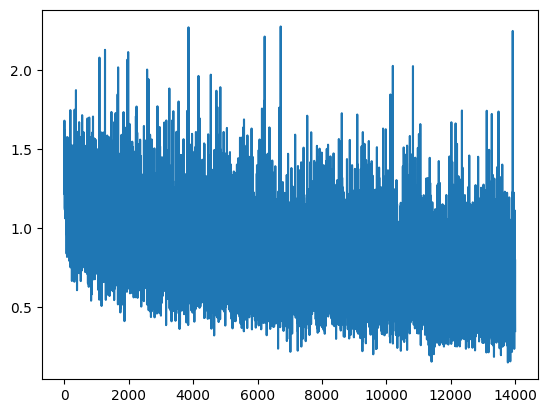

In [17]:
plt.plot(train_losses)

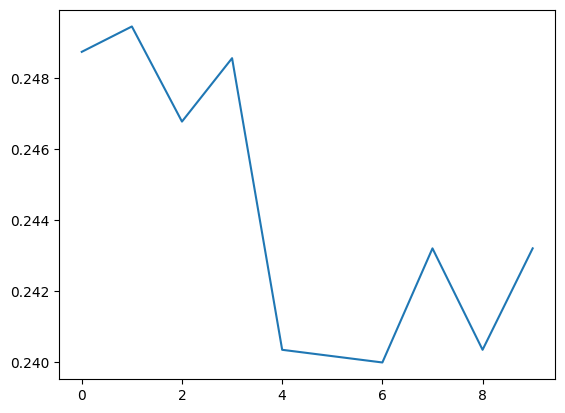

In [18]:
plt.plot(test_accuracy)

In [19]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [20]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 1362/5600 (0.2432)
{'acc_detail': tensor([0.2861, 0.2268, 0.2731, 0.1864], device='cuda:0'),
 'acc_unweighted': tensor(0.2431, device='cuda:0'),
 'acc_weighted': tensor(0.2432, device='cuda:0'),
 'f1s_detail': tensor([0.2583, 0.2325, 0.2656, 0.2101], device='cuda:0'),
 'f1s_unweighted': tensor(0.2416, device='cuda:0'),
 'f1s_weighted': tensor(0.2416, device='cuda:0'),
 'precision_detail': tensor([0.2354, 0.2385, 0.2585, 0.2406], device='cuda:0'),
 'recall_detail': tensor([0.2861, 0.2268, 0.2731, 0.1864], device='cuda:0'),
 'rocauc': tensor(0.4934, device='cuda:0'),
 'rocauc_detail': tensor([0.4883, 0.4835, 0.5082, 0.4937], device='cuda:0'),
 'uar': tensor(0.2431, device='cuda:0'),
 'wap': tensor(0.2432, device='cuda:0')}


tensor([[404, 345, 367, 296],
        [452, 315, 351, 271],
        [427, 333, 382, 257],
        [433, 328, 378, 261]], device='cuda:0')

In [21]:
model_path = '../models_esd4/esd4_m13mel_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [23]:
n_epoch = 10
n_epoch2 = 50

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m13mel_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                    | 0.001142857142857143/50 [00:00<5:01:30, 361.82s/it]

Train Epoch: 11 [0/22400 (0%)]	Loss: 0.409826
Mem before-during-after: 19886592 20030464 22282752


  0%|                                                                    | 0.023999999999999983/50 [00:08<4:51:14, 349.65s/it]

Train Epoch: 11 [640/22400 (3%)]	Loss: 0.340490
Mem before-during-after: 22282752 22425600 22282752


  0%|                                                                    | 0.046857142857142785/50 [00:16<4:43:15, 340.24s/it]

Train Epoch: 11 [1280/22400 (6%)]	Loss: 0.385615
Mem before-during-after: 22282752 22425600 22282752


  0%|                                                                     | 0.06971428571428559/50 [00:23<4:43:24, 340.57s/it]

Train Epoch: 11 [1920/22400 (9%)]	Loss: 0.696808
Mem before-during-after: 22282752 22425600 22282752


  0%|▏                                                                    | 0.09257142857142839/50 [00:31<4:41:32, 338.49s/it]

Train Epoch: 11 [2560/22400 (11%)]	Loss: 0.787380
Mem before-during-after: 22282752 22425600 22282752


  0%|▏                                                                    | 0.11542857142857119/50 [00:39<4:42:26, 339.71s/it]

Train Epoch: 11 [3200/22400 (14%)]	Loss: 0.362448
Mem before-during-after: 22282752 22425600 22282752


  0%|▏                                                                    | 0.13828571428571432/50 [00:47<4:43:47, 341.50s/it]

Train Epoch: 11 [3840/22400 (17%)]	Loss: 0.640539
Mem before-during-after: 22282752 22425600 22282752


  0%|▏                                                                    | 0.16114285714285767/50 [00:55<4:40:59, 338.29s/it]

Train Epoch: 11 [4480/22400 (20%)]	Loss: 0.946817
Mem before-during-after: 22282752 22425600 22282752


  0%|▎                                                                    | 0.18400000000000102/50 [01:02<4:43:13, 341.13s/it]

Train Epoch: 11 [5120/22400 (23%)]	Loss: 1.143161
Mem before-during-after: 22282752 22425600 22282752


  0%|▎                                                                     | 0.1885714285714297/50 [01:04<4:44:14, 342.39s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0639c88be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  0%|▎                                                                    | 0.18914285714285828/50 [01:04<4:45:03, 343.38s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0639c88be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  0%|▎      

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13mel_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)